In [1]:
import os
import copy
import joblib
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
path_save_models = 'models'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cuda


## Resnet18 - dog_cat
Realizar treinamento e validação utilizando Resnet18 e dataset contendo duas classes (cachorros e gatos)

Função para carregar e fazer pré-processamento nas imagens

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path_images, labels, transform, transform_augmentation=None):
        self.path_images = path_images
        self.labels = labels
        self.transform = transform
        self.augmentation = transform_augmentation
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.open(self.path_images[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.augmentation:
            img = self.augmentation(img)
        else:
            img = self.transform(img)

        return img, torch.tensor(np.array([label]), dtype=torch.float32)

Pegar caminho e label das imagens

In [4]:
def get_image_path(path):
    X = []
    y = []
    for cls, folder in enumerate(os.listdir(path)):
        full_path = f'{path}/{folder}'
        for filename in os.listdir(full_path):
            if filename.endswith('jpg') or filename.endswith('png'):
                X.append(f'{full_path}/{filename}')
                y.append(cls)
    return X, y

O seguinte dataset foi descompactado dentro da pasta "dog_cat": https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [5]:
path_train = 'data/dog_cat/training_set/training_set'
path_valid = 'data/dog_cat/test_set/test_set'

X_train, y_train = get_image_path(path_train)
X_valid, y_valid = get_image_path(path_valid)

#### Treinamento

Carregar arquitetura, hiperparâmetros e transformers para fazer pré-processamento nos dados

In [6]:
model = models.resnet18(weights='IMAGENET1K_V1')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

transform_default = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

transform_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [9]:
dataset_train = CustomDataset(X_train, y_train, transform_default, transform_augmentation)
dataset_valid = CustomDataset(X_valid, y_valid, transform_default)

train_loader = torch.utils.data.DataLoader(
                    dataset_train, batch_size=128,
                    shuffle=True, num_workers=4)

valid_loader = torch.utils.data.DataLoader(
                dataset_valid, batch_size=128,
                shuffle=False, num_workers=4)

Realizar treinamento

In [10]:
log_name = ''
dataset_name = 'dog_cat'
total_epoch = 10


if log_name != '':
    writer = SummaryWriter(f'runs/{log_name}')  # 'runs/50'
else:
    writer = SummaryWriter()

results = []
# acc, loss, epoch
best_acc = [0., 0., 0]

for epoch in range(total_epoch):
    torch.cuda.empty_cache()
    model.train()
    running_loss = 0.
    running_accuracy = 0.
    running_p = []
    running_y = []
    for data in tqdm(train_loader):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(torch.sigmoid(outputs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calcule accuracy
        outputs = (torch.sigmoid(outputs) > 0.5).float()
        outputs = outputs.cpu().detach()
        labels = labels.cpu().detach()
        running_accuracy += accuracy_score(labels, outputs)
    writer.add_scalar(f'{dataset_name}-Accuracy/train', running_accuracy/len(train_loader), epoch)
    writer.add_scalar(f'{dataset_name}-Loss/train', running_loss/len(train_loader), epoch)
    print('Epoch {}; Loss {}; Accuracy {}'.format(epoch, running_loss/len(train_loader), running_accuracy/len(train_loader)))

    if epoch % 1 == 0:
        model.eval()
        running_accuracy_valid = 0.
        running_loss_valid = 0.
        running_p2 = []
        running_y2 = []
        for data in tqdm(valid_loader):
            inputs_valid, labels_valid = data
            
            inputs_valid = inputs_valid.to(device)
            labels_valid = labels_valid.to(device)

            outputs_valid = model(inputs_valid)
            loss = criterion(torch.sigmoid(outputs_valid), labels_valid)
            running_loss_valid += loss.item()

            # Calcule accuracy
            outputs_valid = (torch.sigmoid(outputs_valid) > 0.5).float()
            outputs_valid = outputs_valid.cpu().detach()
            labels = labels_valid.cpu().detach()
            running_accuracy_valid += accuracy_score(labels, outputs_valid)
        writer.add_scalar(f'{dataset_name}-Accuracy/valid', running_accuracy_valid/len(valid_loader), epoch)
        writer.add_scalar(f'{dataset_name}-Loss/valid', running_loss_valid/len(valid_loader), epoch)
        print(f'Loss valid {running_loss_valid/len(valid_loader)}; Accuracy valid:{running_accuracy_valid/len(valid_loader)}')
        if running_accuracy_valid/len(valid_loader) > best_acc[0]:
            print('### New best model! ###')
            best_acc = [running_accuracy_valid/len(valid_loader), running_loss_valid/len(valid_loader), epoch]
            best_model = copy.deepcopy(model)
    writer.flush()
writer.flush()

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 0; Loss 0.2149312026680462; Accuracy 0.9074397573038878


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.95006390902563; Accuracy valid:0.72119140625
### New best model! ###


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1; Loss 0.11456036029590501; Accuracy 0.9523108609385784


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.13747059274464846; Accuracy valid:0.9555806280339806
### New best model! ###


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2; Loss 0.10314769989677838; Accuracy 0.960229396710375


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.1494202297180891; Accuracy valid:0.9442316444174758


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3; Loss 0.08791177258605049; Accuracy 0.9658978174603174


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.20482293085660785; Accuracy valid:0.9148020327669903


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4; Loss 0.06359073975019985; Accuracy 0.9773424919484702


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.16835305001586676; Accuracy valid:0.9393488319174758


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5; Loss 0.0714710262559709; Accuracy 0.9721341586151369


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.1758855665102601; Accuracy valid:0.9369216474514563


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6; Loss 0.05688929081790977; Accuracy 0.9777145157579941


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.16242208401672542; Accuracy valid:0.937158677184466


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7; Loss 0.053975277402926056; Accuracy 0.9789366229583621


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.14853878458961844; Accuracy valid:0.9415389866504854


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8; Loss 0.05247705883627373; Accuracy 0.9796285512997469


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.1560303580481559; Accuracy valid:0.9499725045509708


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9; Loss 0.058551691295135586; Accuracy 0.9763684006211181


  0%|          | 0/16 [00:00<?, ?it/s]

Loss valid 0.1718963256571442; Accuracy valid:0.9515700849514563


Salvar o melhor checkpoint (melhor acurácia no dataset de valid)

In [11]:
pathlib.Path(path_save_models).mkdir(exist_ok=True, parents=True)
torch.save(best_model, f'{path_save_models}/dog_cat.pth')

### Inference
Carrega um modelo treinado e realiza inferências

Carrega modelo e transformer com o mesmo pré-processamento que foi realizado no treinamento

In [12]:
best_model = torch.load(f'{path_save_models}/dog_cat.pth')

transform_default = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

#### Inferencia de uma imagem no dataset de validação

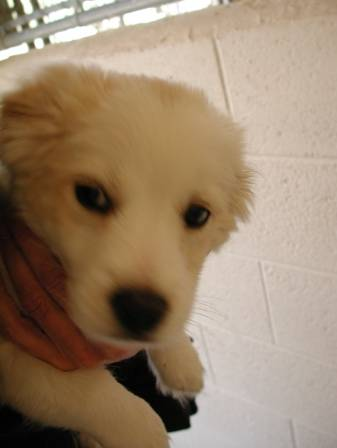

In [13]:
idx = 0
img = Image.open(X_valid[idx]).convert('RGB')
img

In [14]:
input_data = transform_default(img).unsqueeze(0).to(device)
print(f'Real: {y_valid[idx]} - Pred: {int(torch.sigmoid(best_model(input_data))[0][0] > 0.5)} - Prob: {torch.sigmoid(best_model(input_data))[0][0]}')

Real: 0 - Pred: 0 - Prob: 0.03351782634854317


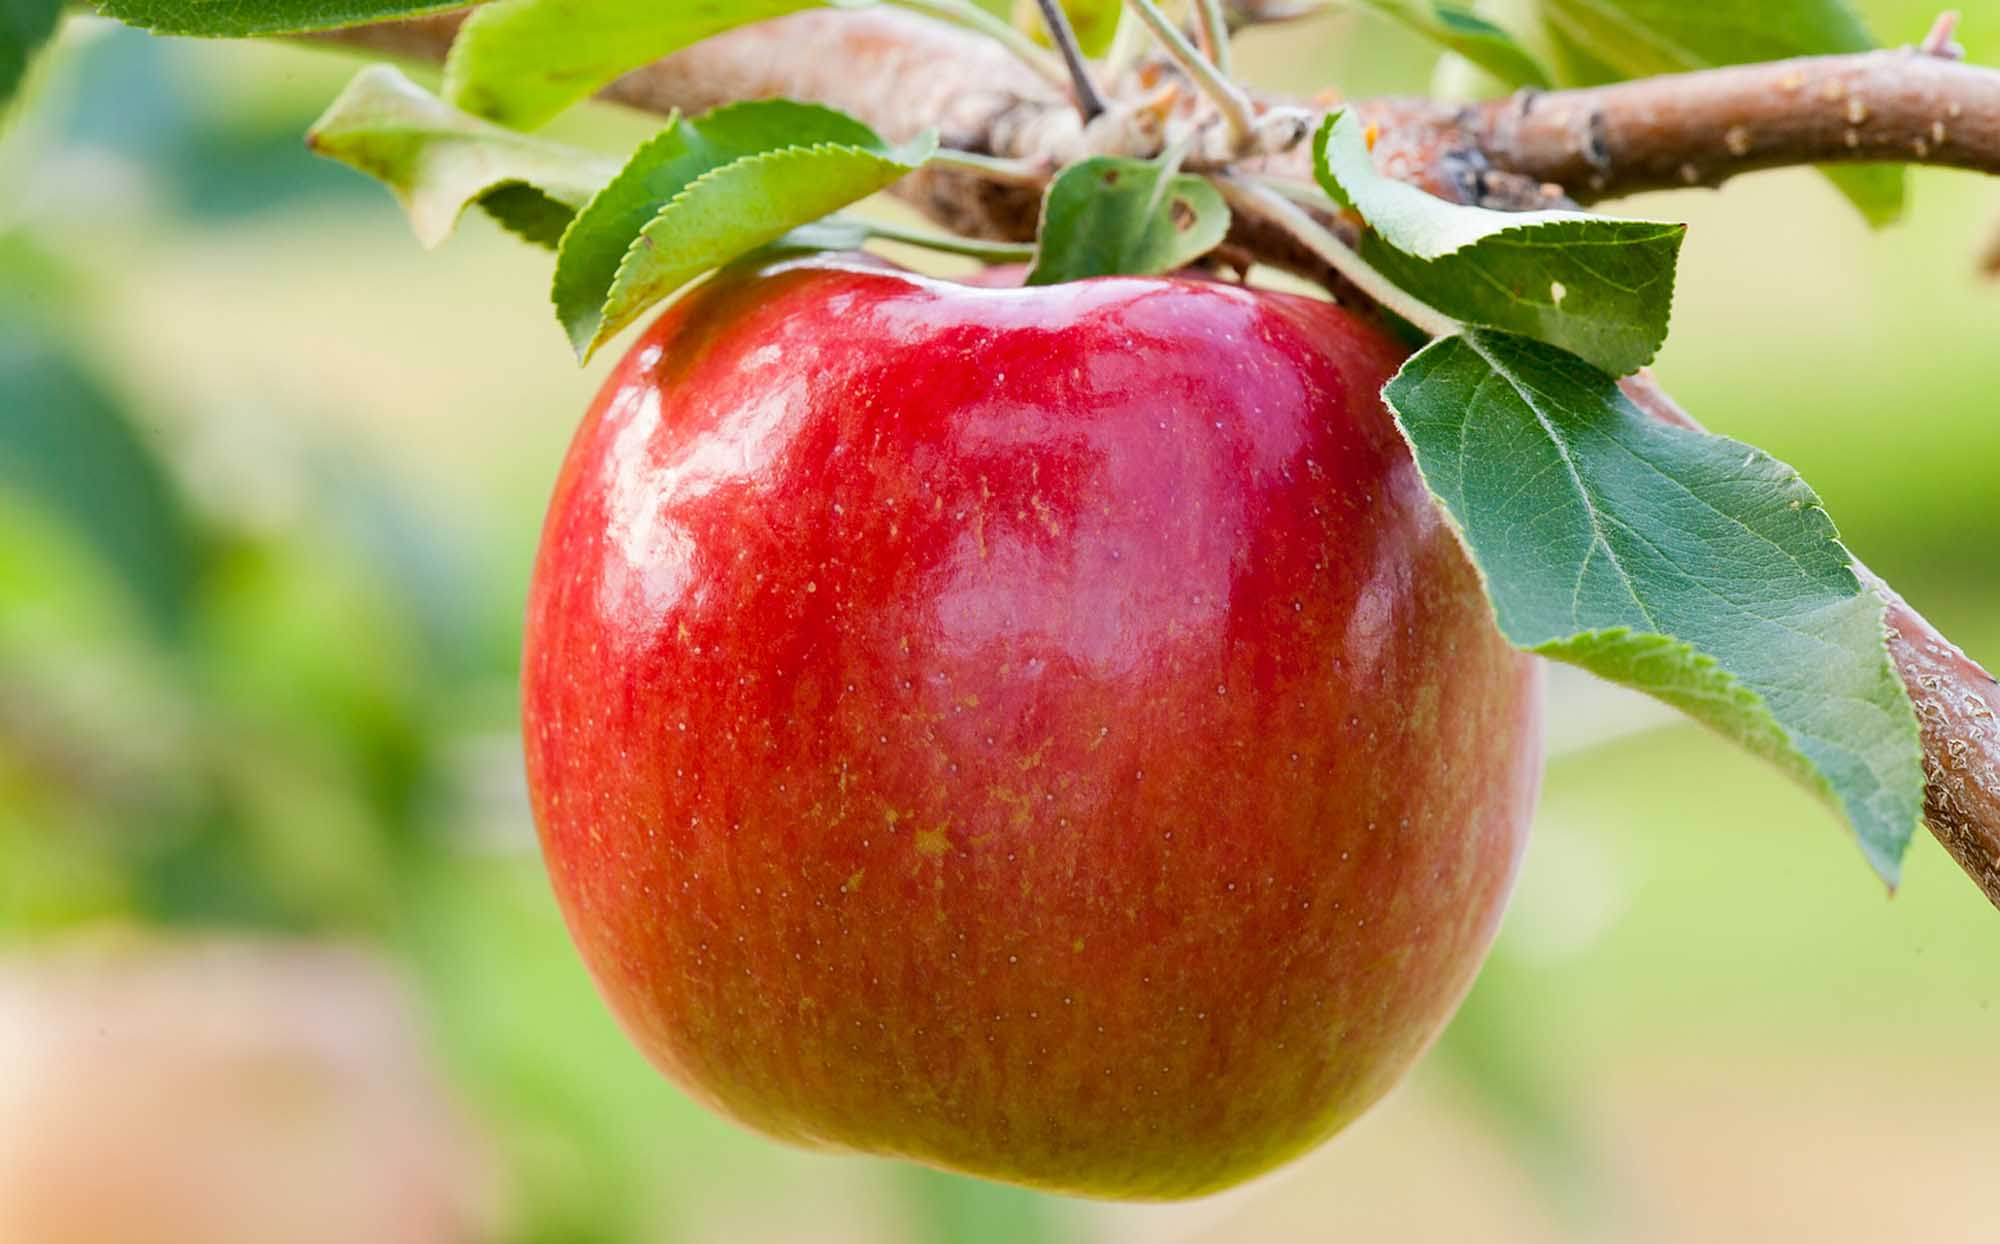

In [15]:
img = Image.open('images/apple.jpg').convert('RGB')
img

In [16]:
input_data = transform_default(img).unsqueeze(0).to(device)
print(f'Pred: {int(torch.sigmoid(best_model(input_data))[0][0] > 0.5)} - Prob: {torch.sigmoid(best_model(input_data))[0][0]}')

Pred: 1 - Prob: 0.6160721182823181


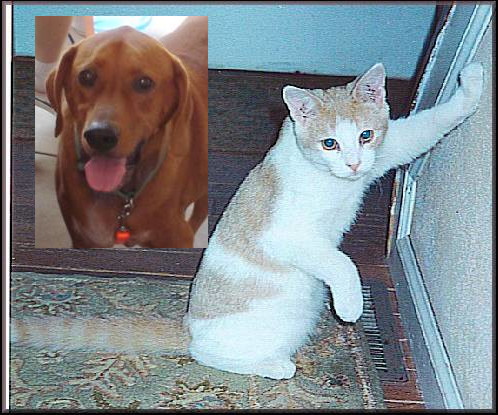

In [17]:
img = Image.open('images/cat_and_dog.jpg').convert('RGB')
img

In [18]:
input_data = transform_default(img).unsqueeze(0).to(device)
print(f'Pred: {int(torch.sigmoid(best_model(input_data))[0][0] > 0.5)} - Prob: {torch.sigmoid(best_model(input_data))[0][0]}')

Pred: 0 - Prob: 0.021759307011961937


#### Grid com resultados e matrix de confusão

In [19]:
pred = []
for data in tqdm(X_valid):
    img = Image.open(data).convert('RGB')
    input_data = transform_default(img).unsqueeze(0).to(device)
    output = best_model(input_data)
    result = torch.sigmoid(output).cpu().detach().numpy()[0][0]
    pred.append(result)

  0%|          | 0/2023 [00:00<?, ?it/s]

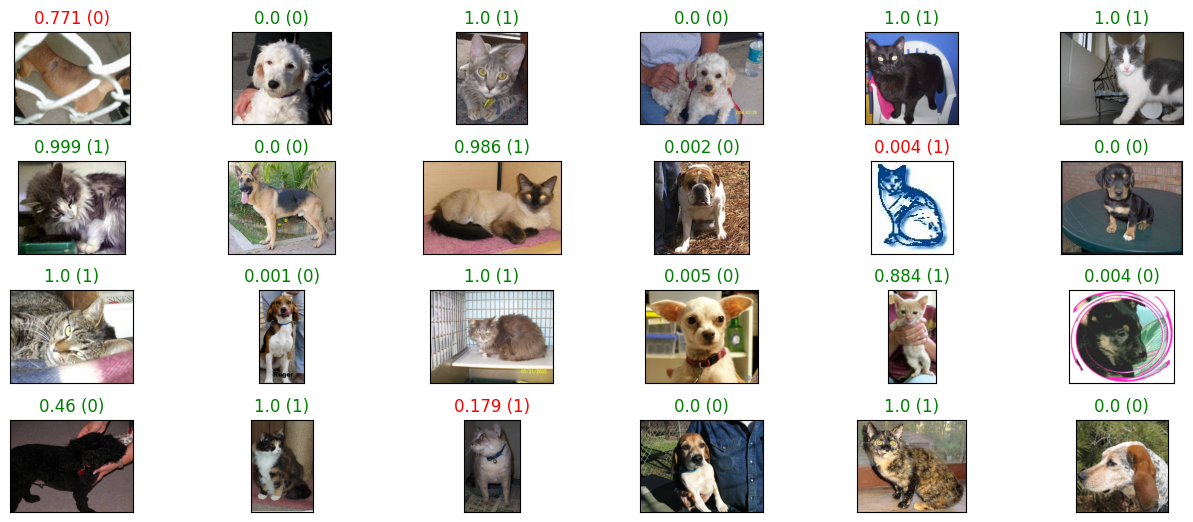

In [20]:
# Exibe alguns exemplos aleatorios do teste, bem como sua predicao e o resultado esperado
num_x = 6
num_y = 4
fig = plt.figure(figsize=(num_y, num_x))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
fig.set_figheight(6)
fig.set_figwidth(15)
for i, idx in enumerate(np.random.choice((len(X_valid)), size=num_x*num_y, replace=False)):
    ax = fig.add_subplot(num_y, num_x, i + 1, xticks=[], yticks=[])
    ax.imshow(Image.open(X_valid[idx]).convert('RGB'))
    ax.set_title("{} ({})".format(round(float(pred[idx]), 3), y_valid[idx]),
                 color=("green" if float(pred[idx] > 0.5) == y_valid[idx] else "red"))

Accuracy: 0.9555116164112704


<Axes: >

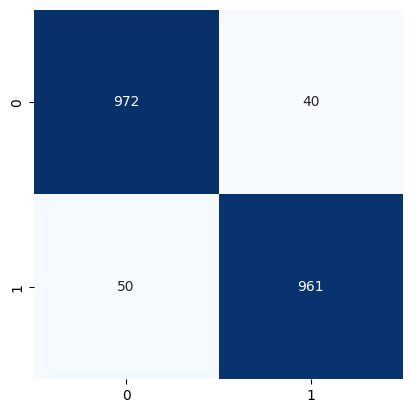

In [21]:
confusion_matrix(y_valid, np.array(pred) > 0.5)

conf_matrix = confusion_matrix(y_valid, np.array(pred) > 0.5)
print(f'Accuracy: {accuracy_score(y_valid, np.array(pred) > 0.5)}')
sns.heatmap(conf_matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

## Efficientnet_b0 - fruit
Realizar treinamento e validação utilizando Efficientnet_b0 e dataset contendo 9 classes

Função para carregar e fazer pré-processamento nas imagens

In [22]:
class CustomDataset(Dataset):
    def __init__(self, path_images, labels, transform, transform_augmentation=None):
        self.path_images = path_images
        self.labels = labels
        self.transform = transform
        self.augmentation = transform_augmentation
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.open(self.path_images[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.augmentation:
            img = self.augmentation(img)
        else:
            img = self.transform(img)

        return img, torch.tensor(np.array([label]), dtype=torch.float32)

Pegar caminho e label das imagens

In [23]:
def get_image_path(path):
    X = []
    y = []
    id_to_class = {}
    for cls, folder in enumerate(os.listdir(path)):
        id_to_class[cls] = folder
        full_path = f'{path}/{folder}'
        for filename in os.listdir(full_path):
            if filename.endswith('jpg') or filename.endswith('png'):
                X.append(f'{full_path}/{filename}')
                y.append(cls)
    return X, y, id_to_class

O seguinte dataset foi descompactado dentro da pasta "fruit": https://www.kaggle.com/datasets/shreyapmaher/fruits-dataset-images

In [24]:
path_train = 'data/fruit/images'

X_train, y_train, id_to_class = get_image_path(path_train)

one_hot = OneHotEncoder(sparse_output=False)
y_train = one_hot.fit_transform(np.array(y_train).reshape(len(y_train), 1))
joblib.dump(one_hot, f'{path_save_models}/oneHot_fruit.joblib')

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)
id_to_class

{0: 'apple fruit',
 1: 'mango fruit',
 2: 'grapes fruit',
 3: 'strawberry fruit',
 4: 'chickoo fruit',
 5: 'orange fruit',
 6: 'banana fruit',
 7: 'kiwi fruit',
 8: 'cherry fruit'}

In [25]:
pd.DataFrame.from_dict(id_to_class, orient='index').to_csv(f'{path_save_models}/id_to_class_fruit.csv', header=None)

In [26]:
print(one_hot.transform([[0]]))
print(one_hot.transform([[1]]))
print(one_hot.transform([[2]]))

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0.]]


#### Treinamento

Carregar arquitetura, hiperparâmetros e transformers para fazer pré-processamento nos dados

In [27]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Alterar a ultima camada densa para a quantidade de classes que iremos usar

In [28]:
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(one_hot.transform([[0]])[0]))
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

transform_default = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

transform_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [30]:
dataset_train = CustomDataset(X_train, y_train, transform_default, transform_augmentation)
dataset_valid = CustomDataset(X_valid, y_valid, transform_default)

train_loader = torch.utils.data.DataLoader(
                    dataset_train, batch_size=32,
                    shuffle=True, num_workers=4)

valid_loader = torch.utils.data.DataLoader(
                dataset_valid, batch_size=32,
                shuffle=False, num_workers=4)

Realizar treinamento

In [31]:
log_name = ''
dataset_name = 'fruit'
total_epoch = 10


if log_name != '':
    writer = SummaryWriter(f'runs/{log_name}')  # 'runs/50'
else:
    writer = SummaryWriter()

results = []
# acc, loss, epoch
best_acc = [0., 0., 0]

for epoch in range(total_epoch):
    torch.cuda.empty_cache()
    model.train()
    running_loss = 0.
    running_accuracy = 0.
    running_p = []
    running_y = []
    for data in tqdm(train_loader):
        inputs, labels = data
        labels = labels.squeeze(1)

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(torch.softmax(outputs, dim=1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calcule accuracy
        outputs = outputs.cpu().detach()
        labels = labels.cpu().detach()
        output_probs, top_class_output = outputs.topk(k = 1, dim = 1)
        label_probs, top_class_label = labels.topk(k = 1, dim = 1)
        running_accuracy += accuracy_score(top_class_label, top_class_output)
    writer.add_scalar(f'{dataset_name}-Accuracy/train', running_accuracy/len(train_loader), epoch)
    writer.add_scalar(f'{dataset_name}-Loss/train', running_loss/len(train_loader), epoch)
    print('Epoch {}; Loss {}; Accuracy {}'.format(epoch, running_loss/len(train_loader), running_accuracy/len(train_loader)))

    if epoch % 1 == 0:
        model.eval()
        running_accuracy_valid = 0.
        running_loss_valid = 0.
        running_p2 = []
        running_y2 = []
        for data in tqdm(valid_loader):
            inputs_valid, labels_valid = data
            labels_valid = labels_valid.squeeze(1)
            
            inputs_valid = inputs_valid.to(device)
            labels_valid = labels_valid.to(device)

            outputs_valid = model(inputs_valid)
            loss = criterion(torch.softmax(outputs_valid, dim=1), labels_valid)
            running_loss_valid += loss.item()

            # Calcule accuracy
            outputs_valid = outputs_valid.cpu().detach()
            labels_valid = labels_valid.cpu().detach()
            output_valid_probs, top_class_output = outputs_valid.topk(k = 1, dim = 1)
            label_probs_valid, top_class_label = labels_valid.topk(k = 1, dim = 1)
            running_accuracy_valid += accuracy_score(top_class_label, top_class_output)
        writer.add_scalar(f'{dataset_name}-Accuracy/valid', running_accuracy_valid/len(valid_loader), epoch)
        writer.add_scalar(f'{dataset_name}-Loss/valid', running_loss_valid/len(valid_loader), epoch)
        print(f'Loss valid {running_loss_valid/len(valid_loader)}; Accuracy valid:{running_accuracy_valid/len(valid_loader)}')
        if running_accuracy_valid/len(valid_loader) > best_acc[0]:
            print('### New best model! ###')
            best_acc = [running_accuracy_valid/len(valid_loader), running_loss_valid/len(valid_loader), epoch]
            best_model = copy.deepcopy(model)
    writer.flush()
writer.flush()

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0; Loss 0.07312021031975746; Accuracy 0.53640625


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.02676135053237279; Accuracy valid:0.8640350877192983
### New best model! ###


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1; Loss 0.01959419052582234; Accuracy 0.9090625


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.01667979049185912; Accuracy valid:0.8952850877192983
### New best model! ###


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2; Loss 0.00854651910776738; Accuracy 0.95484375


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.016835618143280346; Accuracy valid:0.9024122807017544
### New best model! ###


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3; Loss 0.006579015862371307; Accuracy 0.96765625


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.02270626121511062; Accuracy valid:0.8744517543859649


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4; Loss 0.011658654737402685; Accuracy 0.943125


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.014084221795201302; Accuracy valid:0.8991228070175438


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5; Loss 0.006141506077256054; Accuracy 0.95546875


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.01649640950684746; Accuracy valid:0.9128289473684211
### New best model! ###


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6; Loss 0.007865763123845682; Accuracy 0.96484375


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.01477712687725822; Accuracy valid:0.9128289473684211


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7; Loss 0.006889000527735334; Accuracy 0.9665625


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.03125950259466966; Accuracy valid:0.818530701754386


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8; Loss 0.014845562924165279; Accuracy 0.921875


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.036870685716470085; Accuracy valid:0.8152412280701755


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9; Loss 0.00879986907239072; Accuracy 0.9559375


  0%|          | 0/3 [00:00<?, ?it/s]

Loss valid 0.027161475270986557; Accuracy valid:0.8464912280701755


Salvar o melhor checkpoint (melhor acurácia no dataset de valid)

In [32]:
pathlib.Path(path_save_models).mkdir(exist_ok=True, parents=True)
torch.save(best_model, f'{path_save_models}/fruit.pth')

### Inference
Carrega um modelo treinado e realiza inferências

Carrega modelo e transformer com o mesmo pré-processamento que foi realizado no treinamento

In [33]:
best_model = torch.load(f'{path_save_models}/fruit.pth')
one_hot = joblib.load(f'{path_save_models}/oneHot_fruit.joblib')
id_to_class = pd.read_csv(f'{path_save_models}/id_to_class_fruit.csv', index_col=0, header=None)[1].T.to_dict()

transform_default = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

#### Inferencia de uma imagem no dataset de validação

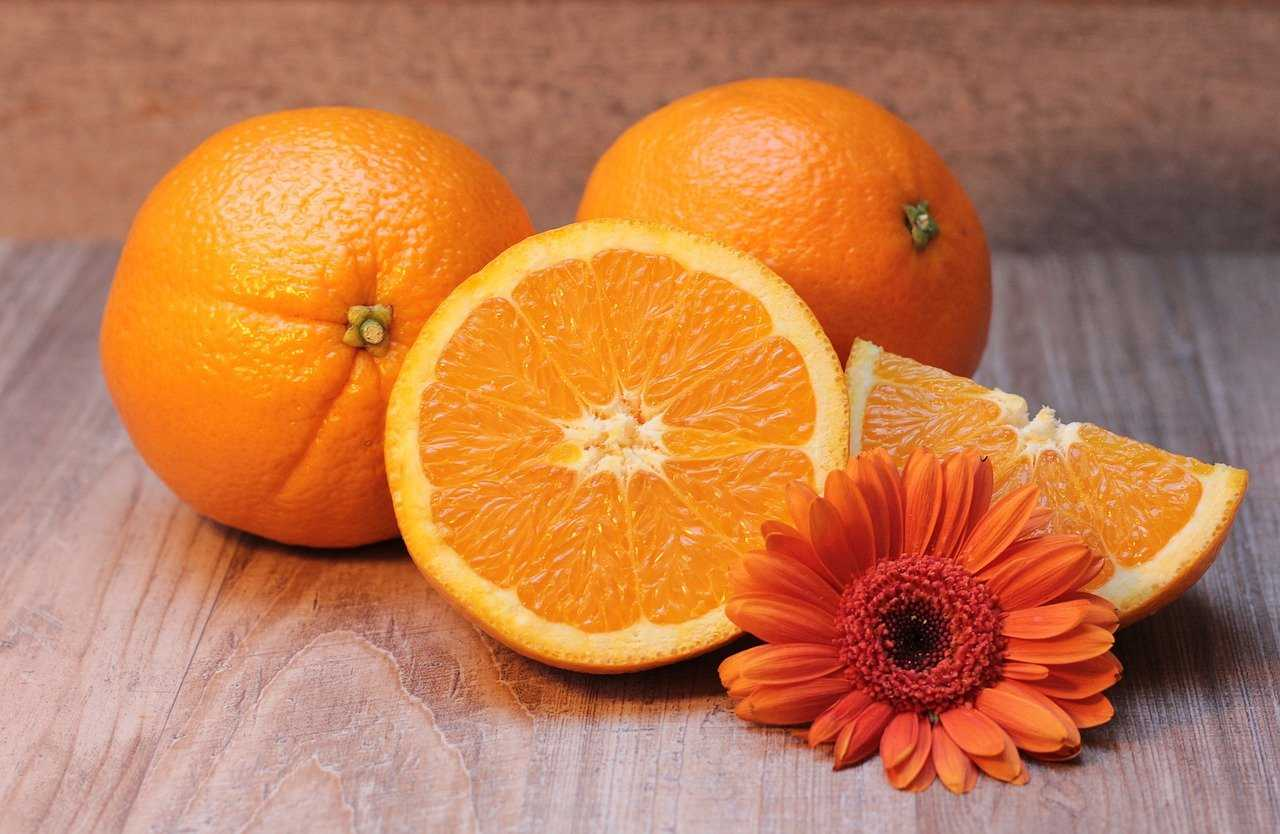

In [34]:
idx = 0
img = Image.open(X_valid[idx]).convert('RGB')
img

In [35]:
input_data = transform_default(img).unsqueeze(0).to(device)
output = best_model(input_data)
output_softmax = torch.softmax(output, dim=1)
output_valid_probs, top_class_output = output_softmax.topk(k = 1, dim = 1)
label_probs_valid, top_class_label = torch.Tensor(y_valid[idx]).unsqueeze(0).topk(k = 1, dim = 1)
print(f'Real: {top_class_label[0][0]}-{id_to_class[int(top_class_label[0][0])]}' +
      f' - pred_class: {top_class_output[0][0]}-{id_to_class[int(top_class_output[0][0])]}' +
      f'\nPred_prob: {output_softmax}')

Real: 5-orange fruit - pred_class: 5-orange fruit
Pred_prob: tensor([[2.8245e-05, 6.7629e-06, 1.2859e-06, 3.2540e-05, 1.9791e-04, 9.9950e-01,
         4.2637e-05, 1.9464e-04, 5.4207e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


#### Grid com resultados e matrix de confusão

In [36]:
pred = []
for data in tqdm(X_valid):
    img = Image.open(data).convert('RGB')
    input_data = transform_default(img).unsqueeze(0).to(device)
    output = best_model(input_data)
    result = torch.softmax(output, dim=1).cpu().detach()
    pred.append(result)

  0%|          | 0/83 [00:00<?, ?it/s]

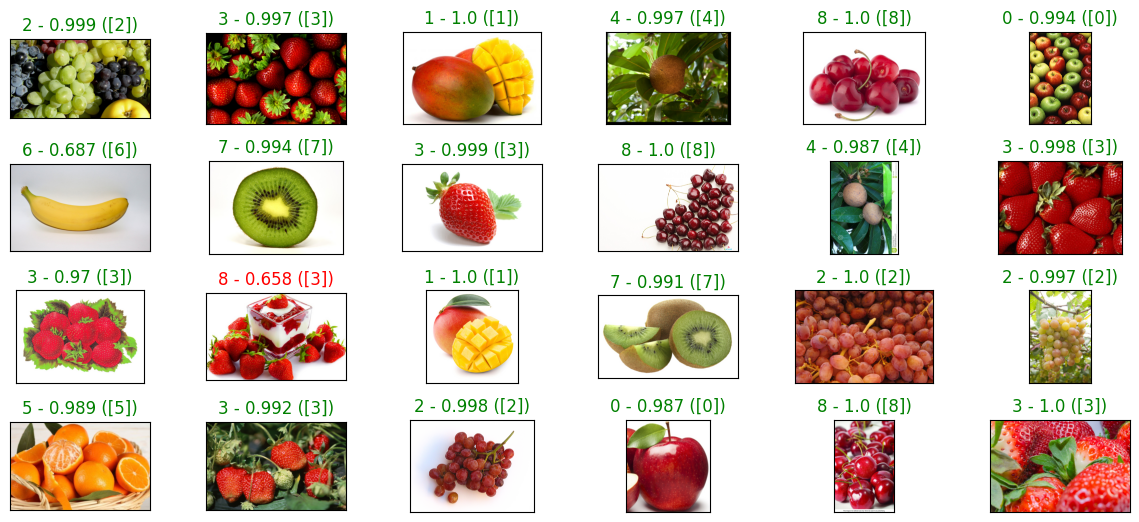

In [37]:
# Exibe alguns exemplos aleatorios do teste, bem como sua predicao e o resultado esperado
num_x = 6
num_y = 4
fig = plt.figure(figsize=(num_y, num_x))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
fig.set_figheight(6)
fig.set_figwidth(14)
y = one_hot.inverse_transform(y_valid)
for i, idx in enumerate(np.random.choice((len(X_valid)), size=num_x*num_y, replace=False)):
    ax = fig.add_subplot(num_y, num_x, i + 1, xticks=[], yticks=[])
    ax.imshow(Image.open(X_valid[idx]).convert('RGB'))
    top_prob, top_class = pred[idx].topk(k = 1, dim = 1)
    ax.set_title("{} - {} ({})".format(int(top_class[0][0]), round(float(top_prob), 3), y[idx]),
                 color=("green" if int(top_class[0][0]) == y[idx] else "red"))

Accuracy: 0.9156626506024096


<Axes: >

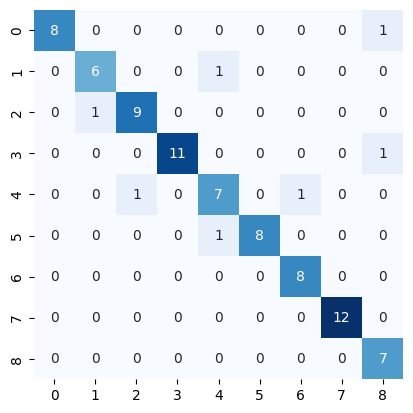

In [38]:
top_probs, top_classes = torch.cat(pred).topk(k = 1, dim = 1)
conf_matrix = confusion_matrix(one_hot.inverse_transform(y_valid), top_classes)
print(f'Accuracy: {accuracy_score(one_hot.inverse_transform(y_valid), top_classes)}')
sns.heatmap(conf_matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)